In [28]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [29]:
import torch
import transformers
from transformers import AutoModelForCausalLM, AutoTokenizer

torch.__version__, transformers.__version__, torch.version.cuda

('1.13.1+cu117', '4.37.2', '11.7')

In [30]:
from src.models import ModelandTokenizer
from src import models

# MODEL_PATH = "gpt2"
MODEL_PATH = "EleutherAI/gpt-j-6B"
# MODEL_PATH = "meta-llama/Llama-2-7b-hf"
# MODEL_PATH = "mistralai/Mistral-7B-v0.1"
# MODEL_PATH = "state-spaces/mamba-2.8b-slimpj" # state-spaces/mamba-2.8b


mt = ModelandTokenizer(
    model_path=MODEL_PATH, 
    torch_dtype=torch.float16
)

## Attention Matrix

In [47]:
@torch.inference_mode()
def get_attention_matrices(
    prompt: str, 
    mt: ModelandTokenizer,
    value_weighted: bool = False
) -> torch.tensor:
    """
    Parameters:
        prompt: str, input prompt
        mt: ModelandTokenizer, model and tokenizer
        value_weighted: bool. 
            - False => will reuturn attention masks for each key-value pair (after softmax). This is the attention mask actually produced inside the model
            - True => will consider the value matrices to give a sense of the actual contribution of source tokens to the target token residual.
    Returns:
        attention matrices: torch.tensor of shape (layers, heads, tokens, tokens)
    """
    # ! doesn't support batching yet. not really needed in this project
    assert isinstance(prompt, str), "Prompt must be a string"

    inputs = mt.tokenizer(prompt, return_tensors='pt').to(mt.device)
    output = mt.model(**inputs, output_attentions=True) # batch_size x n_tokens x vocab_size, only want last token prediction
    attentions = torch.vstack(output.attentions) # (layers, heads, tokens, tokens)
    if value_weighted:
        values = torch.vstack([output.past_key_values[i][1] for i in range(mt.n_layer)]) # (layers, heads, tokens, head_dim)
        attentions = torch.einsum("abcd,abd->abcd", attentions, values.norm(dim=-1))
    return attentions

In [48]:
prompt = mt.tokenizer.eos_token + "The quick brown fox jumps over the lazy"

attn = get_attention_matrices(
    prompt,
    mt,
    value_weighted=False
)
attn.shape

torch.Size([28, 16, 9, 9])

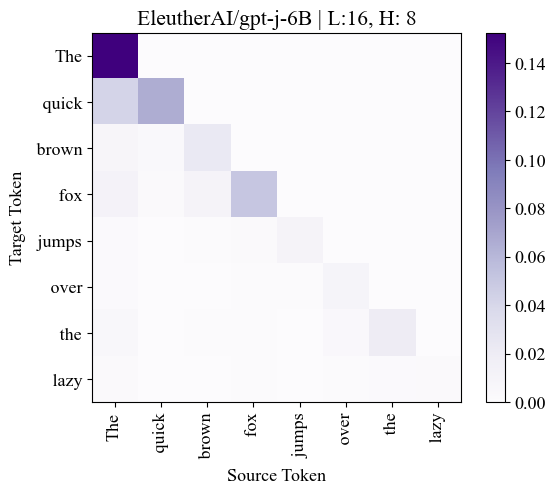

In [53]:
# ! TODO: Visualize the attention matrices

import matplotlib.pyplot as plt
def visualize_attn_matrix(
    prompt: str, 
    attn_matrix: torch.Tensor, 
    remove_eos: bool=True,
    title: str | None = None,
    color_scheme: str = "Blues"
):
    assert attn_matrix.shape[0] == attn_matrix.shape[1], "Attention matrix must be square"

    promt_tokenized = mt.tokenizer(prompt, return_tensors='pt').input_ids
    tokens = [mt.tokenizer.decode([t]) for t in promt_tokenized[0]]
    assert len(tokens) == attn_matrix.shape[-1], "Tokens and attention matrix must have the same length"

    start_idx = 0
    if remove_eos:
        start_idx = 1 if tokens[0] == mt.tokenizer.eos_token else 0

    with plt.rc_context(
        rc={
            "font.family": "Times New Roman",
            "font.size": 13,
        }
    ):

        img = plt.imshow(
            attn_matrix[start_idx:, start_idx:].cpu().numpy(), 
            cmap=color_scheme, 
            interpolation='nearest'
        )
        plt.colorbar(img, orientation='vertical')

        plt.xticks(range(len(tokens)-start_idx), tokens[start_idx:], rotation=90)
        plt.yticks(range(len(tokens)-start_idx), tokens[start_idx:])

        plt.ylabel("Target Token")
        plt.xlabel("Source Token")

        if title:
            plt.title(title)

        plt.show()


#######################################
layer_no = 16
head_no = 8
#######################################

visualize_attn_matrix(
    prompt, 
    attn[layer_no, head_no], 
    remove_eos=True, 
    title = f"{MODEL_PATH} | L:{layer_no}, H: {head_no}",
    color_scheme="Purples"
)

## Causal Tracing

### Corrupting the Subject tokens

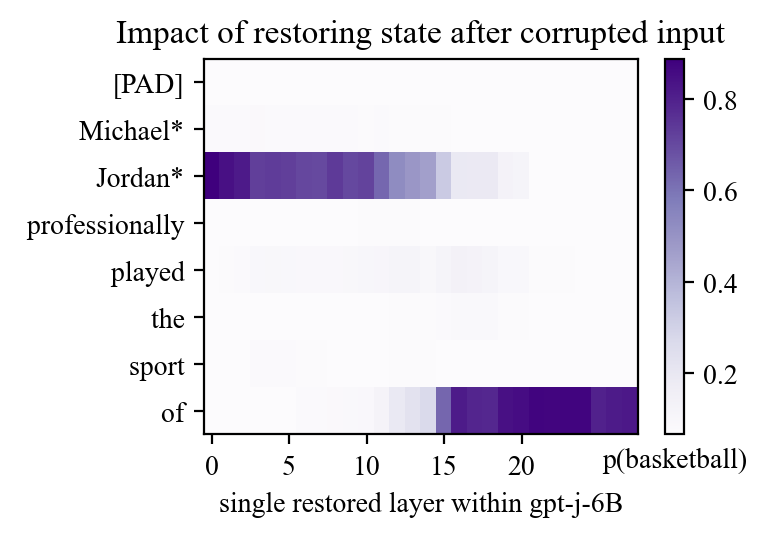

In [34]:
from src.tracing import calculate_hidden_flow
from src.plotting import plot_trace_heatmap

prompt_template = mt.tokenizer.eos_token + " {} professionally played the sport of"

subject = "Michael Jordan"
prompt = prompt_template.format(subject)

indirect_effects = calculate_hidden_flow(
    mt = mt,
    prompt = prompt,
    subject = subject,
)
plot_trace_heatmap(indirect_effects, modelname=MODEL_PATH.split("/")[-1])

--------------------------------------------------------------------------------
module_type='mlp'


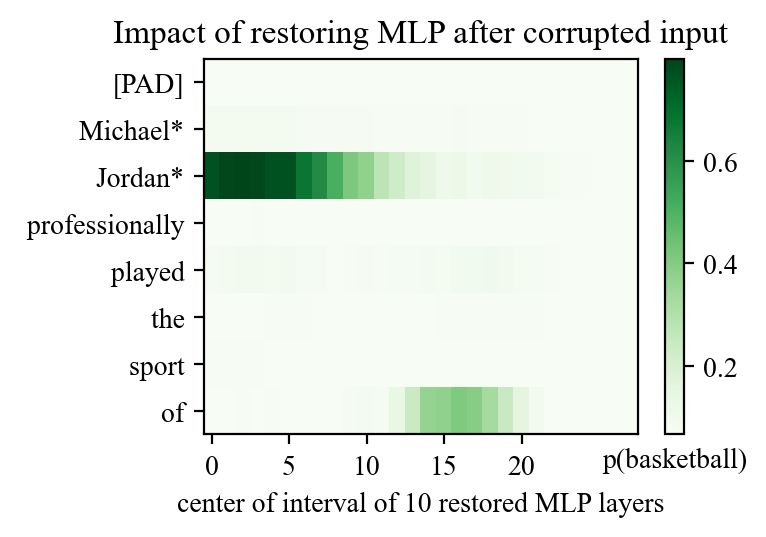

--------------------------------------------------------------------------------
module_type='attn'


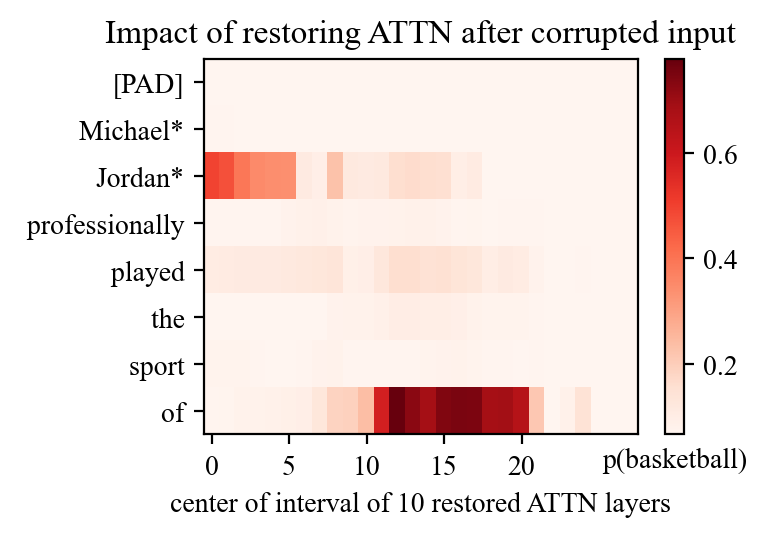

In [35]:
# from src.hooking.mamba import MambaBlock_Hook_Points
# from typing import get_args

# for mamba_block_hook in get_args(MambaBlock_Hook_Points):
for module_type in ["mlp", "attn"]:
    print("-"*80)
    print(f"{module_type=}")
    mt.reset_forward()
    indirect_effects = calculate_hidden_flow(
        mt = mt,
        prompt = prompt,
        subject = subject,
        kind=module_type,
    )
    plot_trace_heatmap(indirect_effects, modelname=MODEL_PATH.split("/")[-1])

### Patching from an alternate subject
> Gives cleaner results

In [41]:
###################################################
prompt_template = mt.tokenizer.eos_token + " {} professionally played the sport of"

subject = "Michael Jordan"
alt_subject = "Pele"
###################################################

prompt = prompt_template.format(subject)

In [42]:
from src.functional import predict_next_token

predict_next_token(
    mt = mt,
    prompt = [
        prompt_template.format(subject) for subject in [subject, alt_subject]
    ]
)

[[PredictedToken(token=' basketball', prob=0.8238806128501892),
  PredictedToken(token=' baseball', prob=0.04505011811852455),
  PredictedToken(token=' football', prob=0.02195567451417446),
  PredictedToken(token=' Basketball', prob=0.021114565432071686),
  PredictedToken(token=' soccer', prob=0.01750458963215351)],
 [PredictedToken(token=' football', prob=0.33938223123550415),
  PredictedToken(token=' soccer', prob=0.33412060141563416),
  PredictedToken(token=' baseball', prob=0.04417082667350769),
  PredictedToken(token=' basketball', prob=0.03748729079961777),
  PredictedToken(token=' f', prob=0.033866941928863525)]]

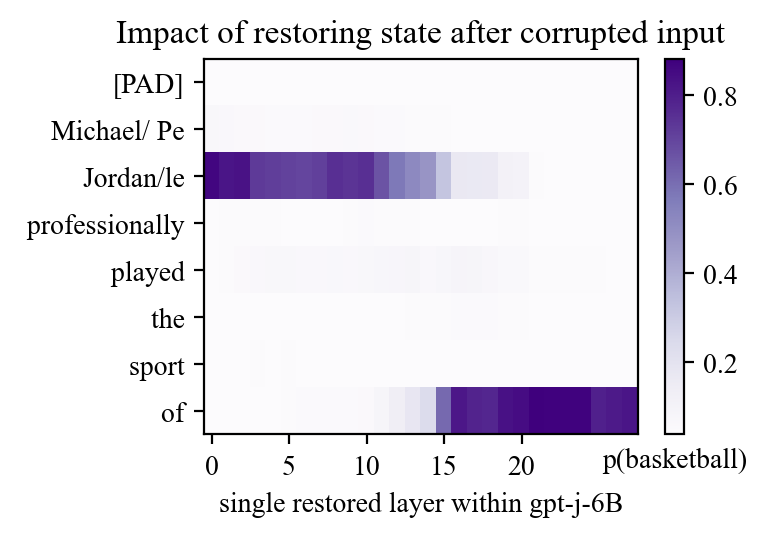

In [43]:
from src.tracing import calculate_hidden_flow
from src.plotting import plot_trace_heatmap

indirect_effects = calculate_hidden_flow(
    mt = mt,
    prompt = prompt_template,
    subject = subject,
    alt_subject = alt_subject
    # subject = alt_subject,
    # alt_subject = subject
)
plot_trace_heatmap(indirect_effects, modelname=MODEL_PATH.split("/")[-1])

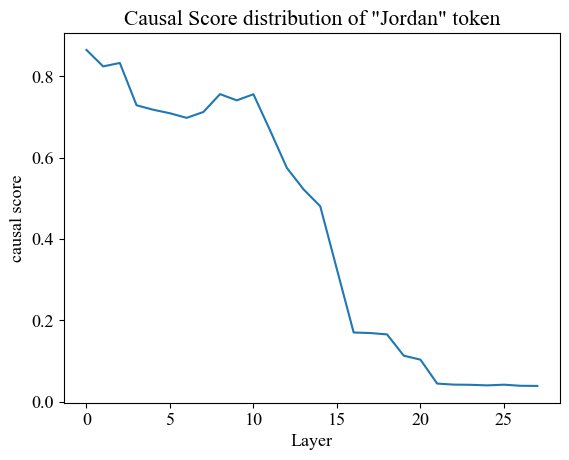

In [44]:
scores = indirect_effects['scores'][2]

with plt.rc_context(
    rc={
        "font.family": "Times New Roman",
        "font.size": 13,
    }
):
    plt.plot(scores)
    plt.ylabel("causal score")
    plt.xlabel("Layer")
    plt.title('Causal Score distribution of "Jordan" token')

--------------------------------------------------------------------------------
module_type='mlp'


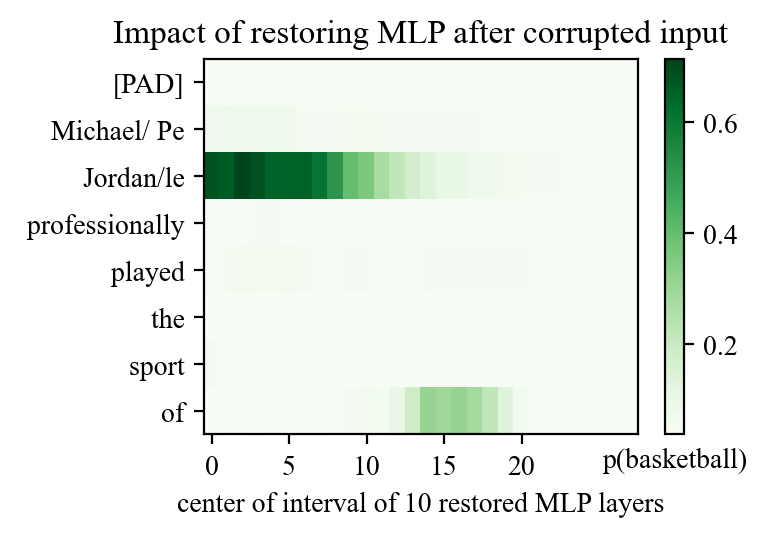

--------------------------------------------------------------------------------
module_type='attn'


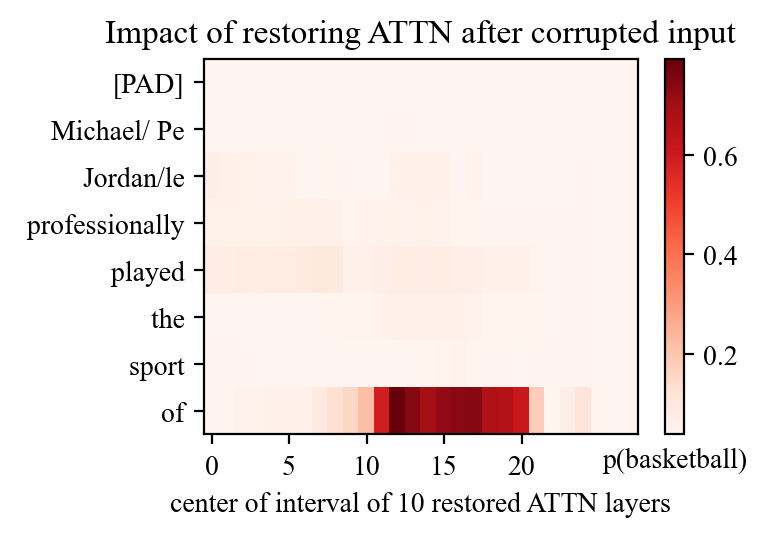

In [45]:
# for mamba_block_hook in get_args(MambaBlock_Hook_Points):
for module_type in ["mlp", "attn"]:
    print("-"*80)
    print(f"{module_type=}")
    mt.reset_forward()
    indirect_effects = calculate_hidden_flow(
        mt = mt,
        prompt = prompt_template,
        subject = subject,
        alt_subject = alt_subject,
        kind=module_type,
    )
    plot_trace_heatmap(indirect_effects, modelname=MODEL_PATH.split("/")[-1])